In [1]:
import collections.abc
from collections import namedtuple
import math
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, Set, Tuple, Union

import numpy as np
import torch
import torch.utils.checkpoint
from torch import nn
import torch.nn.functional as F

In [2]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, add_cls_token=False):
    """
    Create 2D sin/cos positional embeddings.
    Args:
        embed_dim (`int`):
            Embedding dimension.
        grid_size (`int`):
            The grid height and width.
        add_cls_token (`bool`, *optional*, defaults to `False`):
            Whether or not to add a classification (CLS) token.
    Returns:
        (`torch.FloatTensor` of shape (grid_size*grid_size, embed_dim) or (1+grid_size*grid_size, embed_dim): the
        position embeddings (with or without classification token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if add_cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [3]:
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be even")

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

In [4]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position pos: a list of positions to be encoded: size (M,) out: (M, D)
    """
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be even")

    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [5]:
class ViTMAEEmbeddings(nn.Module):
    """
    Construct the CLS token, position and patch embeddings.
    """

    def __init__(self, num_channels, hidden_size, image_size, patch_size, initializer_range, 
                 mask_ratio):
        super().__init__()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.patch_embeddings = ViTMAEPatchEmbeddings(num_channels, hidden_size, image_size, patch_size)
        self.num_patches = self.patch_embeddings.num_patches
        # fixed sin-cos embedding
        self.position_embeddings = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, hidden_size), requires_grad=False
        )
        self.initializer_range = initializer_range
        self.mask_ratio = mask_ratio
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) position embeddings by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(
            self.position_embeddings.shape[-1], int(self.patch_embeddings.num_patches**0.5), add_cls_token=True
        )
        self.position_embeddings.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embeddings like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embeddings.projection.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=self.initializer_range)

    def random_masking(self, sequence, noise=None):
        """
        Perform per-sample random masking by per-sample shuffling. Per-sample shuffling is done by argsort random
        noise.
        Args:
            sequence (`torch.LongTensor` of shape `(batch_size, sequence_length, dim)`)
            noise (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*) which is
                mainly used for testing purposes to control randomness and maintain the reproducibility
        """
        batch_size, seq_length, dim = sequence.shape
        len_keep = int(seq_length * (1 - self.mask_ratio))

        if noise is None:
            noise = torch.rand(batch_size, seq_length, device=sequence.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        sequence_unmasked = torch.gather(sequence, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, dim))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([batch_size, seq_length], device=sequence.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return sequence_unmasked, mask, ids_restore

    def forward(self, pixel_values, noise=None):
        batch_size, num_channels, height, width = pixel_values.shape     
        embeddings = self.patch_embeddings(pixel_values)

        # add position embeddings w/o cls token
        embeddings = embeddings + self.position_embeddings[:, 1:, :]

        # masking: length -> length * config.mask_ratio
        embeddings, mask, ids_restore = self.random_masking(embeddings, noise)

        # append cls token
        cls_token = self.cls_token + self.position_embeddings[:, :1, :]
        cls_tokens = cls_token.expand(embeddings.shape[0], -1, -1)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)

        return embeddings, mask, ids_restore

In [6]:
class ViTMAEPatchEmbeddings(nn.Module):
    """
    This class turns `pixel_values` of shape `(batch_size, num_channels, height, width)` into the initial
    `hidden_states` (patch embeddings) of shape `(batch_size, seq_length, hidden_size)` to be consumed by a
    Transformer.
    """

    def __init__(self, num_channels, hidden_size, image_size, patch_size):
        super().__init__()
        image_size, patch_size = image_size, patch_size
        num_channels, hidden_size = num_channels, hidden_size
        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values):
        batch_size, num_channels, height, width = pixel_values.shape
        if num_channels != self.num_channels:
            raise ValueError(
                "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
            )
        if height != self.image_size[0] or width != self.image_size[1]:
            raise ValueError(
                f"Input image size ({height}*{width}) doesn't match model ({self.image_size[0]}*{self.image_size[1]})."
            )
        x = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return x

In [7]:
class ViTMAESelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob) -> None:
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                f"The hidden size {hidden_size,} is not a multiple of the number of attention "
                f"heads {num_attention_heads}."
            )

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)
        self.key = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)
        self.value = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self, hidden_states, head_mask: Optional[torch.Tensor] = None, output_attentions: bool = False
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs


In [8]:
class ViTMAESelfOutput(nn.Module):
    """
    The residual connection is defined in ViTMAELayer instead of here (as is the case with other models), due to the
    layernorm applied before each block.
    """

    def __init__(self, hidden_size, hidden_dropout_prob) -> None:
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states


In [9]:
class ViTMAEAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob) -> None:
        super().__init__()
        self.attention = ViTMAESelfAttention(hidden_size, num_attention_heads, qkv_bias, 
                                             attention_probs_dropout_prob)
        self.output = ViTMAESelfOutput(hidden_size, hidden_dropout_prob)
        self.pruned_heads = set()

    def prune_heads(self, heads: Set[int]) -> None:
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_outputs = self.attention(hidden_states, head_mask, output_attentions)

        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

In [10]:
class ViTMAEIntermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_act='gelu') -> None:
        super().__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        self.hidden_act = hidden_act

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = getattr(F, self.hidden_act)(hidden_states)

        return hidden_states

In [11]:
class ViTMAEOutput(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_dropout_prob) -> None:
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

In [12]:
class ViTMAELayer(nn.Module):
    """This corresponds to the Block class in the timm implementation."""

    def __init__(self, hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, intermediate_size, layer_norm_eps, chunk_size_feed_forward) -> None:
        super().__init__()
        self.chunk_size_feed_forward = chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = ViTMAEAttention(hidden_size, num_attention_heads, qkv_bias, 
                                         attention_probs_dropout_prob, hidden_dropout_prob)
        self.intermediate = ViTMAEIntermediate(hidden_size, intermediate_size)
        self.output = ViTMAEOutput(hidden_size, intermediate_size, hidden_dropout_prob)
        self.layernorm_before = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(hidden_size, eps=layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViTMAE, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViTMAE, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + outputs

        return outputs


In [13]:
ViTencoder = namedtuple("ViTencoder", ["last_hidden_state", "hidden_states", "attentions"])

In [14]:
class ViTMAEEncoder(nn.Module):
    def __init__(self, hidden_size, num_hidden_layers, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, intermediate_size, 
                 layer_norm_eps, chunk_size_feed_forward) -> None:
        super().__init__()
        self.layer = nn.ModuleList([ViTMAELayer(hidden_size, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, intermediate_size, 
                 layer_norm_eps, chunk_size_feed_forward) for _ in range(num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = True,
    ) -> Union[tuple]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    layer_head_mask,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return ViTencoder(
                last_hidden_state=hidden_states,
                hidden_states=all_hidden_states,
                attentions=all_self_attentions
            )


In [15]:
ViTOutputs = namedtuple("ViTOutputs", ["last_hidden_state", "mask", "ids_restore", "hidden_states", "attentions"])

In [16]:
class ViTMAEModel(nn.Module):
    def __init__(self, num_channels, image_size, patch_size, initializer_range, mask_ratio, 
                 hidden_size, num_hidden_layers, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, intermediate_size, 
                 layer_norm_eps, chunk_size_feed_forward, output_attentions, output_hidden_states, 
                 use_return_dict):
        super().__init__()
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.num_hidden_layers = num_hidden_layers

        self.embeddings = ViTMAEEmbeddings(num_channels, hidden_size, image_size, patch_size, 
                 initializer_range, mask_ratio)
        self.encoder = ViTMAEEncoder(hidden_size, num_hidden_layers, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, intermediate_size, layer_norm_eps, 
                 chunk_size_feed_forward)

        self.layernorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)

        # Initialize weights and apply final processing

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        noise: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, ViTMAEModel
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
        >>> model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> last_hidden_states = outputs.last_hidden_state
        ```"""
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = None
        #head_mask = self.get_head_mask(head_mask, self.num_hidden_layers)

        embedding_output, mask, ids_restore = self.embeddings(pixel_values, noise=noise)

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)

        if not return_dict:
            return ViTOutputs(
                last_hidden_state=sequence_output,
                mask=mask,
                ids_restore=ids_restore,
                hidden_states=encoder_outputs.hidden_states,
                attentions=encoder_outputs.attentions
            )

In [17]:
num_channels = 3
hidden_size = 64
image_size = 64
patch_size = 4
initializer_range = 0.02
mask_ratio = 0.5
num_hidden_layers = 2
num_attention_heads = 2
qkv_bias = True
attention_probs_dropout_prob = 0
hidden_dropout_prob = 0
intermediate_size = 128
layer_norm_eps = 1e-12
chunk_size_feed_forward = 0
output_attentions = True
output_hidden_states = True
use_return_dict = False

model = ViTMAEModel(
    num_channels=num_channels,
    image_size=image_size,
    patch_size=patch_size,
    initializer_range=initializer_range,
    mask_ratio=mask_ratio,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    qkv_bias=qkv_bias,
    attention_probs_dropout_prob=attention_probs_dropout_prob,
    hidden_dropout_prob=hidden_dropout_prob,
    intermediate_size=intermediate_size,
    layer_norm_eps=layer_norm_eps,
    chunk_size_feed_forward=chunk_size_feed_forward,
    output_attentions=output_attentions,
    output_hidden_states=output_hidden_states,
    use_return_dict=use_return_dict
)

In [18]:
sample_image = torch.rand(5, 3, 64, 64)
outputs = model(pixel_values=sample_image)
sequence_output, mask, ids_restore, hidden_states, attentions = outputs
print("sequence_output shape:", sequence_output.shape)
print("mask shape:",mask.shape)
print("ids_restore shape:", ids_restore.shape)

sequence_output shape: torch.Size([5, 129, 64])
mask shape: torch.Size([5, 256])
ids_restore shape: torch.Size([5, 256])


In [19]:
ViTdecoder = namedtuple("ViTdecoder", ["logits", "hidden_states", "attentions"])

In [20]:
class ViTMAEDecoder(nn.Module):
    def __init__(self, num_channels, decoder_num_hidden_layers, patch_size, hidden_size, 
                 decoder_hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, intermediate_size, layer_norm_eps, chunk_size_feed_forward, 
                 initializer_range, num_patches):
        super().__init__()
        self.decoder_embed = nn.Linear(hidden_size, decoder_hidden_size, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_hidden_size))
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, decoder_hidden_size), requires_grad=False
        )  # fixed sin-cos embedding

        self.decoder_layers = nn.ModuleList(
            [ViTMAELayer(hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, intermediate_size, layer_norm_eps, chunk_size_feed_forward) for _ in range(decoder_num_hidden_layers)]
        )

        self.decoder_norm = nn.LayerNorm(decoder_hidden_size, eps=layer_norm_eps)
        self.decoder_pred = nn.Linear(
            decoder_hidden_size, decoder_hidden_size, bias=True
        )  # encoder to decoder
        
        self.upsampling = nn.ConvTranspose2d(hidden_size, num_channels, kernel_size=patch_size, stride=patch_size)
        self.gradient_checkpointing = False
        self.initializer_range = initializer_range
        self.initialize_weights(num_patches)

    def initialize_weights(self, num_patches):
        # initialize (and freeze) position embeddings by sin-cos embedding
        decoder_pos_embed = get_2d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1], int(num_patches**0.5), add_cls_token=True
        )
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=self.initializer_range)

    def forward(
        self,
        hidden_states,
        ids_restore,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=False,
    ):
        # embed tokens
        x = self.decoder_embed(hidden_states)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        hidden_states = x + self.decoder_pos_embed

        # apply Transformer layers (blocks)
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        for i, layer_module in enumerate(self.decoder_layers):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    None,
                )
            else:
                layer_outputs = layer_module(hidden_states, head_mask=None, output_attentions=output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        hidden_states = self.decoder_norm(hidden_states)

        # predictor projection
        logits = self.decoder_pred(hidden_states)

        # remove cls token
        logits = logits[:, 1:, :]
        batch_size, height_width, embed_dim = logits.shape
        logits = logits.transpose(1, 2).view(batch_size, embed_dim, int(height_width**(1/2)), int(height_width**(1/2)))
        logits = self.upsampling(logits)
        

        if not return_dict:
            return ViTdecoder(
                logits=logits,
                hidden_states=all_hidden_states,
                attentions=all_self_attentions
            )

In [21]:
ViTMAEForPreTrainingOutput = namedtuple("ViTMAEForPreTrainingOutput", ["logits", "mask", "ids_restore", "hidden_states", "attentions"])

In [22]:
class ViTMAEForPreTraining(nn.Module):
    def __init__(self, num_channels, image_size, patch_size, initializer_range, mask_ratio, 
                 hidden_size, decoder_hidden_size, num_hidden_layers, decoder_num_hidden_layers, 
                 num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, 
                 intermediate_size, layer_norm_eps, chunk_size_feed_forward, norm_pix_loss, 
                 output_attentions, output_hidden_states, use_return_dict):
        super().__init__()
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.norm_pix_loss = norm_pix_loss
        self.use_return_dict = use_return_dict

        self.vit = ViTMAEModel(num_channels, image_size, patch_size, initializer_range, mask_ratio, 
                 hidden_size, num_hidden_layers, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, intermediate_size, 
                 layer_norm_eps, chunk_size_feed_forward, output_attentions, output_hidden_states, 
                 use_return_dict)
        self.decoder = ViTMAEDecoder(num_channels, decoder_num_hidden_layers, patch_size, hidden_size, 
                 decoder_hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, intermediate_size, layer_norm_eps, chunk_size_feed_forward, 
                 initializer_range, num_patches=self.vit.embeddings.num_patches)

        # Initialize weights and apply final processing

    def get_input_embeddings(self):
        return self.vit.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def patchify(self, pixel_values):
        """
        Args:
            pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
                Pixel values.
        Returns:
            `torch.FloatTensor` of shape `(batch_size, num_patches, patch_size**2 * num_channels)`:
                Patchified pixel values.
        """
        patch_size, num_channels = self.patch_size, self.num_channels
        # sanity checks
        if (pixel_values.shape[2] != pixel_values.shape[3]) or (pixel_values.shape[2] % patch_size != 0):
            raise ValueError("Make sure the pixel values have a squared size that is divisible by the patch size")
        if pixel_values.shape[1] != num_channels:
            raise ValueError(
                "Make sure the number of channels of the pixel values is equal to the one set in the configuration"
            )

        # patchify
        batch_size = pixel_values.shape[0]
        num_patches_one_direction = pixel_values.shape[2] // patch_size
        patchified_pixel_values = pixel_values.reshape(
            batch_size, num_channels, num_patches_one_direction, patch_size, num_patches_one_direction, patch_size
        )
        patchified_pixel_values = torch.einsum("nchpwq->nhwpqc", patchified_pixel_values)
        patchified_pixel_values = patchified_pixel_values.reshape(
            batch_size, num_patches_one_direction * num_patches_one_direction, patch_size**2 * num_channels
        )
        return patchified_pixel_values

    def unpatchify(self, patchified_pixel_values):
        """
        Args:
            patchified_pixel_values (`torch.FloatTensor` of shape `(batch_size, num_patches, patch_size**2 * num_channels)`:
                Patchified pixel values.
        Returns:
            `torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`:
                Pixel values.
        """
        patch_size, num_channels = self.patch_size, self.num_channels
        num_patches_one_direction = int(patchified_pixel_values.shape[1] ** 0.5)
        # sanity check
        if num_patches_one_direction**2 != patchified_pixel_values.shape[1]:
            raise ValueError("Make sure that the number of patches can be squared")

        # unpatchify
        batch_size = patchified_pixel_values.shape[0]
        patchified_pixel_values = patchified_pixel_values.reshape(
            batch_size,
            num_patches_one_direction,
            num_patches_one_direction,
            patch_size,
            patch_size,
            num_channels,
        )
        patchified_pixel_values = torch.einsum("nhwpqc->nchpwq", patchified_pixel_values)
        pixel_values = patchified_pixel_values.reshape(
            batch_size,
            num_channels,
            num_patches_one_direction * patch_size,
            num_patches_one_direction * patch_size,
        )
        return pixel_values

    def forward_loss(self, pixel_values, pred, mask):
        """
        Args:
            pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
                Pixel values.
            pred (`torch.FloatTensor` of shape `(batch_size, num_patches, patch_size**2 * num_channels)`:
                Predicted pixel values.
            mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
                Tensor indicating which patches are masked (1) and which are not (0).
        Returns:
            `torch.FloatTensor`: Pixel reconstruction loss.
        """
        target = self.patchify(pixel_values)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.0e-6) ** 0.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        noise: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, ViTMAEForPreTraining
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
        >>> model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> loss = outputs.loss
        >>> mask = outputs.mask
        >>> ids_restore = outputs.ids_restore
        ```"""
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        outputs = self.vit(
            pixel_values,
            noise=noise,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        latent = outputs.last_hidden_state
        ids_restore = outputs.ids_restore
        mask = outputs.mask

        decoder_outputs = self.decoder(latent, ids_restore)
        logits = decoder_outputs.logits  # shape (batch_size, num_patches, patch_size*patch_size*num_channels)

        #loss = self.forward_loss(pixel_values, logits, mask)

        if not return_dict:
            return ViTMAEForPreTrainingOutput(
                logits=logits,
                mask=mask,
                ids_restore=ids_restore,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions
            )

In [23]:
num_channels=3
image_size=64
patch_size=4
initializer_range=0.02
mask_ratio=0.5
hidden_size=64
decoder_hidden_size=64
num_hidden_layers=2
decoder_num_hidden_layers=2
num_attention_heads=2
qkv_bias=True,
attention_probs_dropout_prob=0
hidden_dropout_prob=0
intermediate_size=128
layer_norm_eps=1e-12
chunk_size_feed_forward=0
norm_pix_loss=True
output_attentions=True
output_hidden_states=True
use_return_dict=False

modelMAE = ViTMAEForPreTraining(
    num_channels=num_channels,
    image_size=image_size,
    patch_size=patch_size,
    initializer_range=initializer_range,
    mask_ratio=mask_ratio,
    hidden_size=hidden_size,
    decoder_hidden_size=decoder_hidden_size,
    num_hidden_layers=num_hidden_layers,
    decoder_num_hidden_layers=decoder_num_hidden_layers,
    num_attention_heads=num_attention_heads,
    qkv_bias=qkv_bias,
    attention_probs_dropout_prob=attention_probs_dropout_prob,
    hidden_dropout_prob=hidden_dropout_prob,
    intermediate_size=intermediate_size,
    layer_norm_eps=layer_norm_eps,
    chunk_size_feed_forward=chunk_size_feed_forward,
    norm_pix_loss=norm_pix_loss,
    output_attentions=output_attentions,
    output_hidden_states=output_hidden_states,
    use_return_dict=use_return_dict
)

In [24]:
sample_image = torch.rand(5, 3, 64, 64)
outputs = modelMAE(pixel_values=sample_image)
logits, mask, ids_restore, hidden_states, attentions = outputs
print("logits shape:", logits.shape)
print("ids_restore shape:", ids_restore.shape)

logits shape: torch.Size([5, 3, 64, 64])
ids_restore shape: torch.Size([5, 256])


In [25]:
import os
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [26]:
class CustomDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_images = sorted(glob.glob(os.path.join(lr_folder, '*')))
        self.hr_images = sorted(glob.glob(os.path.join(hr_folder, '*')))
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(self.lr_images[idx]).convert('RGB')
        hr_image = Image.open(self.hr_images[idx]).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [27]:
from torch.utils.data import DataLoader

# Set paths for low-resolution and high-resolution image folders
lr_folder = 'D:\deep learning specialization\Vision Transformer\DIV2K_train_LR_bicubic_X2'
hr_folder = 'D:\deep learning specialization\Vision Transformer\DIV2K_train_LR_bicubic_X2'

# Create dataset and data loader
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CustomDataset(lr_folder, hr_folder, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [28]:
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(modelMAE.parameters(), lr=0.001)

In [29]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [30]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

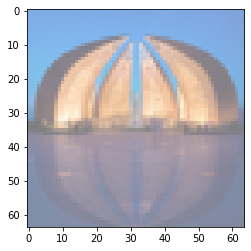

In [31]:
imshow(torchvision.utils.make_grid(images[0]))

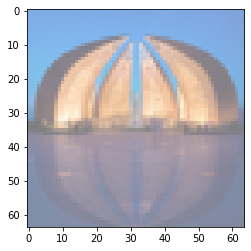

In [32]:
imshow(torchvision.utils.make_grid(labels[0]))

In [33]:
num_epochs = 100
device = torch.device('cpu')

In [34]:
for epoch in range(num_epochs):
    for i, (lr_images, hr_images) in enumerate(tqdm(data_loader)):
        # Move data to the GPU
        lr_images = lr_images.to(device=device)
        hr_images = hr_images.to(device=device)

        # Forward pass
        outputs =  modelMAE(lr_images)
        logits, mask, ids_restore, hidden_states, attentions = outputs      
        loss = loss_function(logits, hr_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.19it/s]

Epoch: 0 Loss: 0.04411652684211731


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.57it/s]

Epoch: 1 Loss: 0.03201250359416008


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.53it/s]

Epoch: 2 Loss: 0.029678111895918846


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.024256819859147072


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.30it/s]

Epoch: 4 Loss: 0.020662536844611168


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.04it/s]

Epoch: 5 Loss: 0.018197983503341675


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.53it/s]

Epoch: 6 Loss: 0.016080427914857864


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.21it/s]

Epoch: 7 Loss: 0.014706403017044067


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.38it/s]

Epoch: 8 Loss: 0.013234484009444714


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.13it/s]

Epoch: 9 Loss: 0.01702040433883667


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.35it/s]

Epoch: 10 Loss: 0.01618635095655918


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.013827850110828876


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.37it/s]

Epoch: 12 Loss: 0.014931335113942623


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.10it/s]

Epoch: 13 Loss: 0.01316565740853548


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.45it/s]

Epoch: 14 Loss: 0.010660125873982906


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.19it/s]

Epoch: 15 Loss: 0.013685985468327999


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.013892185874283314


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.14it/s]

Epoch: 17 Loss: 0.011591047048568726


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.63it/s]

Epoch: 18 Loss: 0.010777264833450317


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.62it/s]

Epoch: 19 Loss: 0.009849931113421917


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.19it/s]

Epoch: 20 Loss: 0.013249577023088932


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.99it/s]

Epoch: 21 Loss: 0.012999165803194046


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.46it/s]

Epoch: 22 Loss: 0.012535597197711468


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.08it/s]

Epoch: 23 Loss: 0.011228390969336033


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.68it/s]

Epoch: 24 Loss: 0.010728769935667515


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.49it/s]

Epoch: 25 Loss: 0.011812624521553516


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.99it/s]

Epoch: 26 Loss: 0.010818272829055786


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.76it/s]

Epoch: 27 Loss: 0.011627908796072006


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 28 Loss: 0.009994854219257832


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.69it/s]

Epoch: 29 Loss: 0.012168758548796177


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.09it/s]

Epoch: 30 Loss: 0.008521365001797676


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 31 Loss: 0.012805395759642124


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.19it/s]

Epoch: 32 Loss: 0.009522121399641037


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.13it/s]

Epoch: 33 Loss: 0.009993473999202251


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 34 Loss: 0.013604588806629181


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.25it/s]

Epoch: 35 Loss: 0.009020179510116577


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 36 Loss: 0.010397887788712978


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.88it/s]

Epoch: 37 Loss: 0.013973926194012165


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.21it/s]

Epoch: 38 Loss: 0.010187403298914433


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.80it/s]

Epoch: 39 Loss: 0.008651371113955975


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.55it/s]

Epoch: 40 Loss: 0.010299808345735073


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.76it/s]

Epoch: 41 Loss: 0.01021707896143198


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  4.97it/s]

Epoch: 42 Loss: 0.010268766433000565


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 43 Loss: 0.011622880585491657


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.46it/s]

Epoch: 44 Loss: 0.007520081475377083


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 45 Loss: 0.011301524005830288


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.62it/s]

Epoch: 46 Loss: 0.009917110204696655


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 47 Loss: 0.008108607493340969


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  4.95it/s]

Epoch: 48 Loss: 0.01108276192098856


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.78it/s]

Epoch: 49 Loss: 0.00873115099966526


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.29it/s]

Epoch: 50 Loss: 0.00888141617178917


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.63it/s]

Epoch: 51 Loss: 0.00889579951763153


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.80it/s]

Epoch: 52 Loss: 0.008678981103003025


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.14it/s]

Epoch: 53 Loss: 0.007618038449436426


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.04it/s]

Epoch: 54 Loss: 0.008953256532549858


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.75it/s]

Epoch: 55 Loss: 0.00913854781538248


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.93it/s]

Epoch: 56 Loss: 0.009941517375409603


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.10it/s]

Epoch: 57 Loss: 0.0096983527764678


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.47it/s]

Epoch: 58 Loss: 0.007829178124666214


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.95it/s]

Epoch: 59 Loss: 0.008066224865615368


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.09it/s]

Epoch: 60 Loss: 0.010031514801084995


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.99it/s]

Epoch: 61 Loss: 0.010438273660838604


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 62 Loss: 0.007119397167116404


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.52it/s]

Epoch: 63 Loss: 0.010726735927164555


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.81it/s]

Epoch: 64 Loss: 0.010583124123513699


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.37it/s]

Epoch: 65 Loss: 0.008861118927598


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.29it/s]

Epoch: 66 Loss: 0.01100069284439087


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.71it/s]

Epoch: 67 Loss: 0.008928780443966389


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.85it/s]

Epoch: 68 Loss: 0.008553680963814259


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 69 Loss: 0.009497647173702717


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  4.92it/s]

Epoch: 70 Loss: 0.009094558656215668


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.30it/s]

Epoch: 71 Loss: 0.007842082530260086


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.13it/s]

Epoch: 72 Loss: 0.007394792977720499


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.81it/s]

Epoch: 73 Loss: 0.008242509327828884


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 74 Loss: 0.006635178346186876


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 75 Loss: 0.00782203208655119


  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.69it/s]

Epoch: 76 Loss: 0.007312650326639414


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 77 Loss: 0.01130058616399765


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  8.13it/s]

Epoch: 78 Loss: 0.010733301751315594


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 79 Loss: 0.008288013748824596


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 80 Loss: 0.007727098185569048


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 81 Loss: 0.0077364821918308735


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.92it/s]

Epoch: 82 Loss: 0.009931427426636219


  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.15it/s]

Epoch: 83 Loss: 0.008267550729215145


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.99it/s]

Epoch: 84 Loss: 0.00947132520377636


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.99it/s]

Epoch: 85 Loss: 0.007665211800485849


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.04it/s]

Epoch: 86 Loss: 0.006930354982614517


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.81it/s]

Epoch: 87 Loss: 0.01134368684142828


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.69it/s]

Epoch: 88 Loss: 0.008099057711660862


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.57it/s]

Epoch: 89 Loss: 0.007965427823364735


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.94it/s]

Epoch: 90 Loss: 0.008551458828151226


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.04it/s]

Epoch: 91 Loss: 0.008080709725618362


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.93it/s]

Epoch: 92 Loss: 0.008623565547168255


  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.85it/s]

Epoch: 93 Loss: 0.008905764669179916


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  6.06it/s]

Epoch: 94 Loss: 0.009371109306812286


  2%|█▋                                                                                 | 1/50 [00:00<00:08,  5.92it/s]

Epoch: 95 Loss: 0.00963776744902134


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 96 Loss: 0.007677294313907623


  2%|█▋                                                                                 | 1/50 [00:00<00:06,  7.75it/s]

Epoch: 97 Loss: 0.009026882238686085


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 98 Loss: 0.008074695244431496


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]

Epoch: 99 Loss: 0.00782921351492405


In [35]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


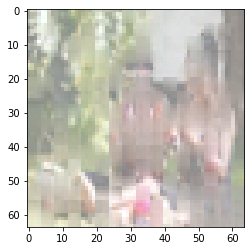

In [36]:
Restoration = modelMAE(images.to(device=device))
imshow(torchvision.utils.make_grid(Restoration[0][0]))

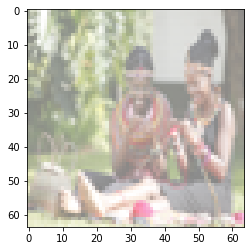

In [37]:
imshow(torchvision.utils.make_grid(labels[0]))